## Center for Machine Perception: Semantic Segmentation v2

Dataset Source: https://huggingface.co/datasets/Xpitfire/cmp_facade

##### Install Necessary Libraries Not Already Installed

In [1]:
%pip install --upgrade pip
%pip install --upgrade datasets transformers evaluate 
%pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


##### Import Necessary Libraries

In [2]:
import sys

from PIL import ImageDraw, ImageFont, Image
import PIL.Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import load_dataset

import torch
from torchvision.transforms import ColorJitter

import transformers
from transformers import Trainer, TrainingArguments, pipeline
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation

import evaluate

!git lfs install

NOTE: Redirects are currently not supported in Windows or MacOs.


Git LFS initialized.


##### Display Versions of Relevant Libraries Used

In [3]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)

        Python: 3.9.12
         NumPy: 1.23.3
        Pandas: 1.5.0
      Datasets: 2.9.0
  Transformers: 4.26.1
         Torch: 1.12.1
      Evaluate: 0.4.0


#### Split into Training & Validation Datasets (80/20 Split)

In [4]:
ds = load_dataset("Xpitfire/cmp_facade")

ds

Using custom data configuration Xpitfire--cmp_facade-642b435710aeac91
Found cached dataset parquet (/Users/briandunn/.cache/huggingface/datasets/Xpitfire___parquet/Xpitfire--cmp_facade-642b435710aeac91/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


A Jupyter Widget

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 378
    })
    test: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 114
    })
    eval: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 114
    })
})

#### Some Information About Dataset

In [5]:
print(len(ds['train']))
print(len(ds['test']))
print(len(ds['eval']))
print(ds['train'][12])
print(ds['test'][12])
print(ds['eval'][12])

378
114
114
{'pixel_values': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=996x1024 at 0x7F900A1DCD90>, 'label': <PIL.PngImagePlugin.PngImageFile image mode=P size=996x1024 at 0x7F8FF99E3EB0>}
{'pixel_values': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=762x1024 at 0x7F900A21C190>, 'label': <PIL.PngImagePlugin.PngImageFile image mode=P size=762x1024 at 0x7F900A21C100>}
{'pixel_values': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x1024 at 0x7F900A21C1C0>, 'label': <PIL.PngImagePlugin.PngImageFile image mode=P size=768x1024 at 0x7F900A21C070>}


#### Converting Between Label String Names & Integer Values

In [6]:
NUM_LABELS = 12

id2label= {
    0 : "background",
    1: "facade", 
    2: "window", 
    3: "door", 
    4: "cornice", 
    5: "sill", 
    6: "balcony", 
    7: "blind",  
    8: "molding",
    9: "deco", 
    10: "pillar",
    11: "shop"
}

label2id = {
    "background": 0,
    "facade": 1, 
    "window": 2, 
    "door": 3, 
    "cornice": 4, 
    "sill": 5, 
    "balcony": 6, 
    "blind": 7,  
    "molding": 8,
    "deco": 9, 
    "pillar": 10,
    "shop": 11
}

#### Basic Values/Constants

In [7]:
MODEL_CKPT = "nvidia/mit-b0"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-CMP_semantic_seg_with_mps_v2"

LEARNING_RATE = 6e-5
REPORTS_TO = "tensorboard"

BATCH_SIZE = 2
ACC_STEPS = 5

NUM_OF_EPOCHS = 50
STRATEGY = "epoch"

DEVICE = torch.device("mps")

#### Initialize Image Processor

In [8]:
image_processor = AutoImageProcessor.from_pretrained(
    MODEL_CKPT, 
    do_reduce_labels=True, 
    reduce_labels=True)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


#### Data Augmentation

In [9]:
jitter = ColorJitter(
    brightness=0.50, 
    contrast=0.50, 
    saturation=0.50, 
    hue=0.25)

#### Create Preprocessing Function for Training Dataset

In [10]:
def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch["pixel_values"]]
    labels = [x for x in example_batch["label"]]
    inputs = image_processor(images, labels)
    return inputs

#### Create Preprocessing Function for Evaluation Dataset

In [11]:
def val_transforms(example_batch):
    images = [x for x in example_batch["pixel_values"]]
    labels = [x for x in example_batch["label"]]
    inputs = image_processor(images, labels)
    return inputs

#### Apply Appropriate Transforms Function to Appropriate Dataset

In [12]:
ds['train'].set_transform(train_transforms)
ds['eval'].set_transform(val_transforms)

#### Create Function to Compute Metrics

In [13]:
def compute_metrics(eval_pred):
    metric = evaluate.load("mean_iou")
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = torch.nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)
        
        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=NUM_LABELS,
            ignore_index=255,
            reduce_labels=False,
        )
        for k, v in metrics.items():
            if type(v) is np.ndarray:
                metrics[k] = v.tolist()
        return metrics            

#### Instantiate Model

In [14]:
model = AutoModelForSemanticSegmentation.from_pretrained(
    MODEL_CKPT, 
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
).to(DEVICE)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.classifier.weight', 'decode_head.batch_norm.weight', 'decode_head.linear_f

#### Define Training Arguments

In [15]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_OF_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    logging_strategy=STRATEGY,
    logging_first_step =True,
    eval_accumulation_steps=ACC_STEPS,
    report_to=REPORTS_TO,
    remove_unused_columns=False,
    hub_private_repo=True,
    push_to_hub=True
)

#### Instantiate Trainer

In [16]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds['train'],
    eval_dataset=ds['eval'],
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/DunnBC22/mit-b0-CMP_semantic_seg_with_mps_v2 into local empty directory.


#### Train Model

In [17]:
train_results = trainer.train()

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 378
  Num Epochs = 50
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 9450
  Number of trainable parameters = 3717228


A Jupyter Widget

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


{'loss': 2.5262, 'learning_rate': 5.99936507936508e-05, 'epoch': 0.01}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 1.6807, 'learning_rate': 5.88e-05, 'epoch': 1.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.4634848754539228, 0.4904852778454534, 0.46977704569302975, 0.0, 0.2307151510822336, 0.1514544832853459, 0.2789258993918792, 0.00016499086657702878, 0.025041827030813847, 0.352690972773565, 0.0, 0.20870390711516645]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6133050341852593, 0.6847324966008382, 0.7408221401485373, 0.0, 0.4973004839882741, 0.17200650361654793, 0.40732489541824046, 0.0001650039483087631, 0.025531707230508505, 0.6371460564807566, 0.0, 0.2873760665242915]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-189
Configuration saved in mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint

{'eval_loss': 1.3309863805770874, 'eval_mean_iou': 0.22262036921149894, 'eval_mean_accuracy': 0.3388091990117969, 'eval_overall_accuracy': 0.589336495650442, 'eval_per_category_iou': [0.4634848754539228, 0.4904852778454534, 0.46977704569302975, 0.0, 0.2307151510822336, 0.1514544832853459, 0.2789258993918792, 0.00016499086657702878, 0.025041827030813847, 0.352690972773565, 0.0, 0.20870390711516645], 'eval_per_category_accuracy': [0.6133050341852593, 0.6847324966008382, 0.7408221401485373, 0.0, 0.4973004839882741, 0.17200650361654793, 0.40732489541824046, 0.0001650039483087631, 0.025531707230508505, 0.6371460564807566, 0.0, 0.2873760665242915], 'eval_runtime': 178.2805, 'eval_samples_per_second': 0.639, 'eval_steps_per_second': 0.32, 'epoch': 1.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 1.1837, 'learning_rate': 5.76e-05, 'epoch': 2.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.42398908351573905, 0.5249246480736364, 0.5152434848293298, 0.005690230903397841, 0.2635974341951505, 0.2755809091452123, 0.3311735486250948, 0.05749007051827676, 0.05389332245480737, 0.3859935747028547, 0.0, 0.2853646425269243]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.47824737936996214, 0.7843921681114081, 0.6966173473129366, 0.005693923012331629, 0.5735250918240624, 0.36835801828416304, 0.6226168977672956, 0.05767745156759108, 0.056265139348553275, 0.590726524634641, 0.0, 0.4168074942998339]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-378
Configuration saved in mit-b0-CMP_semantic

{'eval_loss': 1.1731079816818237, 'eval_mean_iou': 0.260245079124202, 'eval_mean_accuracy': 0.38757728629439825, 'eval_overall_accuracy': 0.6121906481291118, 'eval_per_category_iou': [0.42398908351573905, 0.5249246480736364, 0.5152434848293298, 0.005690230903397841, 0.2635974341951505, 0.2755809091452123, 0.3311735486250948, 0.05749007051827676, 0.05389332245480737, 0.3859935747028547, 0.0, 0.2853646425269243], 'eval_per_category_accuracy': [0.47824737936996214, 0.7843921681114081, 0.6966173473129366, 0.005693923012331629, 0.5735250918240624, 0.36835801828416304, 0.6226168977672956, 0.05767745156759108, 0.056265139348553275, 0.590726524634641, 0.0, 0.4168074942998339], 'eval_runtime': 176.8198, 'eval_samples_per_second': 0.645, 'eval_steps_per_second': 0.322, 'epoch': 2.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 1.0241, 'learning_rate': 5.6399999999999995e-05, 'epoch': 3.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.544236592535624, 0.5037386625623217, 0.5329218083584913, 0.04122383911052976, 0.30619502152348865, 0.2714354684133538, 0.3820197861637806, 0.14297161063544225, 0.07955891090548743, 0.4007127942336929, 0.00016528217339936458, 0.2928537512847711]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8125893617699244, 0.6851517629316499, 0.6682812855352882, 0.041991381045239105, 0.49715664486119526, 0.34177557441959217, 0.5120585878274232, 0.1452966910279639, 0.08494893658553898, 0.5882194328558888, 0.00016528267929344714, 0.36715775790027544]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-567
Config

{'eval_loss': 1.048511266708374, 'eval_mean_iou': 0.29150279399169854, 'eval_mean_accuracy': 0.3953993916199394, 'eval_overall_accuracy': 0.6392809215344881, 'eval_per_category_iou': [0.544236592535624, 0.5037386625623217, 0.5329218083584913, 0.04122383911052976, 0.30619502152348865, 0.2714354684133538, 0.3820197861637806, 0.14297161063544225, 0.07955891090548743, 0.4007127942336929, 0.00016528217339936458, 0.2928537512847711], 'eval_per_category_accuracy': [0.8125893617699244, 0.6851517629316499, 0.6682812855352882, 0.041991381045239105, 0.49715664486119526, 0.34177557441959217, 0.5120585878274232, 0.1452966910279639, 0.08494893658553898, 0.5882194328558888, 0.00016528267929344714, 0.36715775790027544], 'eval_runtime': 174.8035, 'eval_samples_per_second': 0.652, 'eval_steps_per_second': 0.326, 'epoch': 3.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.9353, 'learning_rate': 5.520000000000001e-05, 'epoch': 4.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5776214269254855, 0.5288803999129291, 0.5390827265612298, 0.11713595022489943, 0.3136957294778408, 0.2599635547204301, 0.3664072211017248, 0.15260766464267558, 0.10744437711526733, 0.3934636797021606, 0.00017752366727167548, 0.3077800811435604]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8079444953737089, 0.7362094443096117, 0.6802560980516426, 0.12306993011845858, 0.512920197647116, 0.33239396237919133, 0.42117282716339, 0.15535336024112006, 0.12232149987134326, 0.5586955195187552, 0.0001775258407225914, 0.37512767340369557]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-756
Configurati

{'eval_loss': 0.9943069219589233, 'eval_mean_iou': 0.3053550279329562, 'eval_mean_accuracy': 0.402136877826563, 'eval_overall_accuracy': 0.6570078197278475, 'eval_per_category_iou': [0.5776214269254855, 0.5288803999129291, 0.5390827265612298, 0.11713595022489943, 0.3136957294778408, 0.2599635547204301, 0.3664072211017248, 0.15260766464267558, 0.10744437711526733, 0.3934636797021606, 0.00017752366727167548, 0.3077800811435604], 'eval_per_category_accuracy': [0.8079444953737089, 0.7362094443096117, 0.6802560980516426, 0.12306993011845858, 0.512920197647116, 0.33239396237919133, 0.42117282716339, 0.15535336024112006, 0.12232149987134326, 0.5586955195187552, 0.0001775258407225914, 0.37512767340369557], 'eval_runtime': 174.8108, 'eval_samples_per_second': 0.652, 'eval_steps_per_second': 0.326, 'epoch': 4.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.8717, 'learning_rate': 5.4000000000000005e-05, 'epoch': 5.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.4789569963484104, 0.5505570737975362, 0.5471873633057979, 0.15467212233555622, 0.33717136211833587, 0.329740742665955, 0.41510254600978613, 0.23386662917089512, 0.17093499015002273, 0.4080746205043383, 0.0008171084765058361, 0.3313602667418111]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.5407883204047401, 0.8110534967992339, 0.7439010923003654, 0.1647386208284467, 0.5336310060432693, 0.47195496826220606, 0.5649886876937538, 0.24592767041211344, 0.21268289220340186, 0.6032254750148772, 0.0008172310253953776, 0.43432067432191235]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-945
Configura

{'eval_loss': 1.0010114908218384, 'eval_mean_iou': 0.3298701518020792, 'eval_mean_accuracy': 0.4440025112758097, 'eval_overall_accuracy': 0.6529758185671087, 'eval_per_category_iou': [0.4789569963484104, 0.5505570737975362, 0.5471873633057979, 0.15467212233555622, 0.33717136211833587, 0.329740742665955, 0.41510254600978613, 0.23386662917089512, 0.17093499015002273, 0.4080746205043383, 0.0008171084765058361, 0.3313602667418111], 'eval_per_category_accuracy': [0.5407883204047401, 0.8110534967992339, 0.7439010923003654, 0.1647386208284467, 0.5336310060432693, 0.47195496826220606, 0.5649886876937538, 0.24592767041211344, 0.21268289220340186, 0.6032254750148772, 0.0008172310253953776, 0.43432067432191235], 'eval_runtime': 175.3004, 'eval_samples_per_second': 0.65, 'eval_steps_per_second': 0.325, 'epoch': 5.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.8238, 'learning_rate': 5.28e-05, 'epoch': 6.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5571670792200062, 0.552517395473414, 0.5610617087380155, 0.2076087504784398, 0.34338117214442276, 0.3163128468568835, 0.4103397088272378, 0.3279466924300978, 0.21069994391811445, 0.41911356194559607, 0.006694874564878166, 0.34182469738367616]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6870234926100193, 0.7532167332054568, 0.7388529233923034, 0.2427845747080173, 0.5081350142927471, 0.41732749265984126, 0.5923295163811956, 0.37097280542070116, 0.31168646797334587, 0.6181032158263363, 0.006828623287105196, 0.47847452206299584]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-1134
Configurati

{'eval_loss': 0.9536656141281128, 'eval_mean_iou': 0.3545557026650652, 'eval_mean_accuracy': 0.4771446151516721, 'eval_overall_accuracy': 0.6701067874306127, 'eval_per_category_iou': [0.5571670792200062, 0.552517395473414, 0.5610617087380155, 0.2076087504784398, 0.34338117214442276, 0.3163128468568835, 0.4103397088272378, 0.3279466924300978, 0.21069994391811445, 0.41911356194559607, 0.006694874564878166, 0.34182469738367616], 'eval_per_category_accuracy': [0.6870234926100193, 0.7532167332054568, 0.7388529233923034, 0.2427845747080173, 0.5081350142927471, 0.41732749265984126, 0.5923295163811956, 0.37097280542070116, 0.31168646797334587, 0.6181032158263363, 0.006828623287105196, 0.47847452206299584], 'eval_runtime': 168.386, 'eval_samples_per_second': 0.677, 'eval_steps_per_second': 0.339, 'epoch': 6.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.7708, 'learning_rate': 5.16e-05, 'epoch': 7.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5310075746044994, 0.5633947116318412, 0.5594316197128807, 0.22985789876534993, 0.3424202791715216, 0.3374531065952666, 0.4049849851215688, 0.28826141058185256, 0.21968289277390515, 0.41423929455988057, 0.031575259927696664, 0.3373088073837401]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6050136716074171, 0.7961490880674345, 0.7433683394118146, 0.2875899542681869, 0.5834520174957, 0.4949117910713184, 0.5607636948180663, 0.3102642098935939, 0.3671530482773307, 0.6185428826392109, 0.03448592495554202, 0.4022346714537745]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-1323
Configuration save

{'eval_loss': 0.9789485335350037, 'eval_mean_iou': 0.35496815340250026, 'eval_mean_accuracy': 0.4836607744966159, 'eval_overall_accuracy': 0.6682811870909574, 'eval_per_category_iou': [0.5310075746044994, 0.5633947116318412, 0.5594316197128807, 0.22985789876534993, 0.3424202791715216, 0.3374531065952666, 0.4049849851215688, 0.28826141058185256, 0.21968289277390515, 0.41423929455988057, 0.031575259927696664, 0.3373088073837401], 'eval_per_category_accuracy': [0.6050136716074171, 0.7961490880674345, 0.7433683394118146, 0.2875899542681869, 0.5834520174957, 0.4949117910713184, 0.5607636948180663, 0.3102642098935939, 0.3671530482773307, 0.6185428826392109, 0.03448592495554202, 0.4022346714537745], 'eval_runtime': 168.0061, 'eval_samples_per_second': 0.679, 'eval_steps_per_second': 0.339, 'epoch': 7.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.7415, 'learning_rate': 5.04e-05, 'epoch': 8.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5365875274148131, 0.5659369400475933, 0.5549504785350987, 0.23309033939219542, 0.3497296795169531, 0.33336353690988096, 0.43005316542676975, 0.34005594551228957, 0.19889347759651177, 0.41812008740162165, 0.035787126110042235, 0.2680306895821023]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6081236117125464, 0.8460799406527134, 0.6598362819270074, 0.30354751181463, 0.5720401047797135, 0.4539774768726024, 0.5734811831554486, 0.3848984957854349, 0.26418995057806804, 0.5607853711429407, 0.03791707094605969, 0.2962291208847896]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-1512
Configuration 

{'eval_loss': 0.9738239645957947, 'eval_mean_iou': 0.35538324945382266, 'eval_mean_accuracy': 0.46342551002099625, 'eval_overall_accuracy': 0.6732833259984067, 'eval_per_category_iou': [0.5365875274148131, 0.5659369400475933, 0.5549504785350987, 0.23309033939219542, 0.3497296795169531, 0.33336353690988096, 0.43005316542676975, 0.34005594551228957, 0.19889347759651177, 0.41812008740162165, 0.035787126110042235, 0.2680306895821023], 'eval_per_category_accuracy': [0.6081236117125464, 0.8460799406527134, 0.6598362819270074, 0.30354751181463, 0.5720401047797135, 0.4539774768726024, 0.5734811831554486, 0.3848984957854349, 0.26418995057806804, 0.5607853711429407, 0.03791707094605969, 0.2962291208847896], 'eval_runtime': 168.5315, 'eval_samples_per_second': 0.676, 'eval_steps_per_second': 0.338, 'epoch': 8.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.7018, 'learning_rate': 4.9199999999999997e-05, 'epoch': 9.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5797650959803345, 0.5656555773867602, 0.5624023413616094, 0.23677325096936905, 0.3648405353367248, 0.32706889287510904, 0.42501286148616657, 0.32065864193727883, 0.2096244240088324, 0.4236167832091201, 0.050353847024854216, 0.33460451780818107]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7241302953158243, 0.7684235052379187, 0.7677311546869556, 0.2957821250373002, 0.5320609310645918, 0.42119264423548025, 0.5547462091572214, 0.35133197830090934, 0.2813412242797441, 0.5645280153294033, 0.054445338875404405, 0.4464576433811012]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-1701
Configurati

{'eval_loss': 0.9448630809783936, 'eval_mean_iou': 0.36669806411536165, 'eval_mean_accuracy': 0.48018092207515467, 'eval_overall_accuracy': 0.6825969428346869, 'eval_per_category_iou': [0.5797650959803345, 0.5656555773867602, 0.5624023413616094, 0.23677325096936905, 0.3648405353367248, 0.32706889287510904, 0.42501286148616657, 0.32065864193727883, 0.2096244240088324, 0.4236167832091201, 0.050353847024854216, 0.33460451780818107], 'eval_per_category_accuracy': [0.7241302953158243, 0.7684235052379187, 0.7677311546869556, 0.2957821250373002, 0.5320609310645918, 0.42119264423548025, 0.5547462091572214, 0.35133197830090934, 0.2813412242797441, 0.5645280153294033, 0.054445338875404405, 0.4464576433811012], 'eval_runtime': 171.6382, 'eval_samples_per_second': 0.664, 'eval_steps_per_second': 0.332, 'epoch': 9.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.682, 'learning_rate': 4.8e-05, 'epoch': 10.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5801558465660853, 0.5621958732527232, 0.5584861217084165, 0.23399856724634902, 0.37933715402727797, 0.34066026424016943, 0.42765963009581354, 0.38005799566838694, 0.2300653561261595, 0.42158026982710145, 0.0639705961898374, 0.33669758824413076]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7124128445122457, 0.7649129379639438, 0.7024134248020867, 0.287877946717927, 0.5535415826760965, 0.441309578680332, 0.6309566731585817, 0.4959965113450929, 0.3981571031827014, 0.5591670008934155, 0.07239687432088714, 0.43703921507938964]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-1890
Configuration s

{'eval_loss': 0.9422268271446228, 'eval_mean_iou': 0.3762387719327043, 'eval_mean_accuracy': 0.504681807777725, 'eval_overall_accuracy': 0.6805301465486225, 'eval_per_category_iou': [0.5801558465660853, 0.5621958732527232, 0.5584861217084165, 0.23399856724634902, 0.37933715402727797, 0.34066026424016943, 0.42765963009581354, 0.38005799566838694, 0.2300653561261595, 0.42158026982710145, 0.0639705961898374, 0.33669758824413076], 'eval_per_category_accuracy': [0.7124128445122457, 0.7649129379639438, 0.7024134248020867, 0.287877946717927, 0.5535415826760965, 0.441309578680332, 0.6309566731585817, 0.4959965113450929, 0.3981571031827014, 0.5591670008934155, 0.07239687432088714, 0.43703921507938964], 'eval_runtime': 168.4915, 'eval_samples_per_second': 0.677, 'eval_steps_per_second': 0.338, 'epoch': 10.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.6503, 'learning_rate': 4.6800000000000006e-05, 'epoch': 11.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5192728242868041, 0.5649446824860268, 0.5604780133458106, 0.26978528692233206, 0.37715343417991076, 0.35264087989088694, 0.4341657661288921, 0.3433013918414056, 0.24153761961429152, 0.43359478279525054, 0.08885656663780542, 0.3561829795091815]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.5876217071146836, 0.8059670831465121, 0.7295986604417997, 0.38378984184703785, 0.5267267279434854, 0.4982615891035389, 0.5901717549740297, 0.383783111953036, 0.4151153917819401, 0.5987203244459441, 0.103029264216606, 0.47561876463730435]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-2079
Configuration sa

{'eval_loss': 0.9889266490936279, 'eval_mean_iou': 0.37849285230321655, 'eval_mean_accuracy': 0.5082003518004932, 'eval_overall_accuracy': 0.6729467291581003, 'eval_per_category_iou': [0.5192728242868041, 0.5649446824860268, 0.5604780133458106, 0.26978528692233206, 0.37715343417991076, 0.35264087989088694, 0.4341657661288921, 0.3433013918414056, 0.24153761961429152, 0.43359478279525054, 0.08885656663780542, 0.3561829795091815], 'eval_per_category_accuracy': [0.5876217071146836, 0.8059670831465121, 0.7295986604417997, 0.38378984184703785, 0.5267267279434854, 0.4982615891035389, 0.5901717549740297, 0.383783111953036, 0.4151153917819401, 0.5987203244459441, 0.103029264216606, 0.47561876463730435], 'eval_runtime': 169.0, 'eval_samples_per_second': 0.675, 'eval_steps_per_second': 0.337, 'epoch': 11.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.633, 'learning_rate': 4.5600000000000004e-05, 'epoch': 12.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5539044036240792, 0.5640746106980318, 0.5679376803045576, 0.2657695291519962, 0.3757466434644823, 0.35104871938215626, 0.42571774824305314, 0.39930568333762684, 0.23536352092073748, 0.4338049246523709, 0.18003924612685301, 0.3286865117649982]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6496572223105714, 0.7807274278924162, 0.7448456086694618, 0.4017702861187639, 0.5380576045315403, 0.4614936542558404, 0.5848777216054816, 0.48827668376350436, 0.3247961456216782, 0.6062577678381901, 0.2917759623890081, 0.39577413930071087]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-2268
Configuration s

{'eval_loss': 0.9594061374664307, 'eval_mean_iou': 0.39011660180591196, 'eval_mean_accuracy': 0.5223591853580972, 'eval_overall_accuracy': 0.6797405042146382, 'eval_per_category_iou': [0.5539044036240792, 0.5640746106980318, 0.5679376803045576, 0.2657695291519962, 0.3757466434644823, 0.35104871938215626, 0.42571774824305314, 0.39930568333762684, 0.23536352092073748, 0.4338049246523709, 0.18003924612685301, 0.3286865117649982], 'eval_per_category_accuracy': [0.6496572223105714, 0.7807274278924162, 0.7448456086694618, 0.4017702861187639, 0.5380576045315403, 0.4614936542558404, 0.5848777216054816, 0.48827668376350436, 0.3247961456216782, 0.6062577678381901, 0.2917759623890081, 0.39577413930071087], 'eval_runtime': 168.4694, 'eval_samples_per_second': 0.677, 'eval_steps_per_second': 0.338, 'epoch': 12.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.6035, 'learning_rate': 4.44e-05, 'epoch': 13.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.566287673461385, 0.566596557663215, 0.5678902112592217, 0.26306000852144, 0.3726059238890307, 0.3609025845510209, 0.4351393724436539, 0.37588025008354836, 0.25108473544628496, 0.4256391829733845, 0.1737219533020804, 0.3680641640888084]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6650034015658216, 0.7792062332760352, 0.7595289859518171, 0.40488962602618994, 0.5501279357869723, 0.4940371417476292, 0.583148993385804, 0.4374533247759857, 0.38431984951598447, 0.5591195398258335, 0.25781343258456196, 0.47113291446139877]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-2457
Configuration saved i

{'eval_loss': 0.9612249135971069, 'eval_mean_iou': 0.39390605147358954, 'eval_mean_accuracy': 0.5288151149086694, 'eval_overall_accuracy': 0.6834451441179242, 'eval_per_category_iou': [0.566287673461385, 0.566596557663215, 0.5678902112592217, 0.26306000852144, 0.3726059238890307, 0.3609025845510209, 0.4351393724436539, 0.37588025008354836, 0.25108473544628496, 0.4256391829733845, 0.1737219533020804, 0.3680641640888084], 'eval_per_category_accuracy': [0.6650034015658216, 0.7792062332760352, 0.7595289859518171, 0.40488962602618994, 0.5501279357869723, 0.4940371417476292, 0.583148993385804, 0.4374533247759857, 0.38431984951598447, 0.5591195398258335, 0.25781343258456196, 0.47113291446139877], 'eval_runtime': 168.5841, 'eval_samples_per_second': 0.676, 'eval_steps_per_second': 0.338, 'epoch': 13.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.5874, 'learning_rate': 4.32e-05, 'epoch': 14.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5806677482031424, 0.5670306680818844, 0.567912071302946, 0.2669805280094569, 0.35936413650425275, 0.36049661610517647, 0.43934258727154524, 0.3862602719923495, 0.24060423672069872, 0.4227720940187137, 0.1705185840525888, 0.3651616035455601]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6881466774565245, 0.7714532016797171, 0.7076490702220812, 0.45138479261073833, 0.6010571162888695, 0.4899633082794087, 0.623500155081721, 0.44661640117817103, 0.3626766811886108, 0.5934218960331414, 0.2536721832311539, 0.4702487439000485]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-2646
Configuration save

{'eval_loss': 0.9657226204872131, 'eval_mean_iou': 0.39392592881735955, 'eval_mean_accuracy': 0.5383158522625154, 'eval_overall_accuracy': 0.6844425201416016, 'eval_per_category_iou': [0.5806677482031424, 0.5670306680818844, 0.567912071302946, 0.2669805280094569, 0.35936413650425275, 0.36049661610517647, 0.43934258727154524, 0.3862602719923495, 0.24060423672069872, 0.4227720940187137, 0.1705185840525888, 0.3651616035455601], 'eval_per_category_accuracy': [0.6881466774565245, 0.7714532016797171, 0.7076490702220812, 0.45138479261073833, 0.6010571162888695, 0.4899633082794087, 0.623500155081721, 0.44661640117817103, 0.3626766811886108, 0.5934218960331414, 0.2536721832311539, 0.4702487439000485], 'eval_runtime': 168.7177, 'eval_samples_per_second': 0.676, 'eval_steps_per_second': 0.338, 'epoch': 14.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.5684, 'learning_rate': 4.2e-05, 'epoch': 15.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5799737452083478, 0.5710709114080229, 0.5670764532065862, 0.2824597683542257, 0.36640492159455884, 0.3587419044139626, 0.4407745413968844, 0.4020698579224321, 0.25403099536251994, 0.4246364640946177, 0.13763299473559995, 0.3548388372177615]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6689893935462612, 0.7721150862632795, 0.7253292181715818, 0.46066300719634146, 0.6286397883336339, 0.49001048853338364, 0.5936197648110916, 0.4950579174573106, 0.4336663620311793, 0.6295105616521876, 0.17492722970925553, 0.4629638800334272]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-2835
Configuration sa

{'eval_loss': 0.9762405157089233, 'eval_mean_iou': 0.3949759495762933, 'eval_mean_accuracy': 0.5446243914782444, 'eval_overall_accuracy': 0.6855020021137438, 'eval_per_category_iou': [0.5799737452083478, 0.5710709114080229, 0.5670764532065862, 0.2824597683542257, 0.36640492159455884, 0.3587419044139626, 0.4407745413968844, 0.4020698579224321, 0.25403099536251994, 0.4246364640946177, 0.13763299473559995, 0.3548388372177615], 'eval_per_category_accuracy': [0.6689893935462612, 0.7721150862632795, 0.7253292181715818, 0.46066300719634146, 0.6286397883336339, 0.49001048853338364, 0.5936197648110916, 0.4950579174573106, 0.4336663620311793, 0.6295105616521876, 0.17492722970925553, 0.4629638800334272], 'eval_runtime': 163.2949, 'eval_samples_per_second': 0.698, 'eval_steps_per_second': 0.349, 'epoch': 15.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.5485, 'learning_rate': 4.08e-05, 'epoch': 16.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.4854630804577975, 0.5682984335994403, 0.5685140888867627, 0.26120823705512203, 0.3832057191472071, 0.36282541987900496, 0.43780145913695573, 0.40560224962415387, 0.2525310431655663, 0.42061673773784075, 0.1242392711214882, 0.28249058067528676]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.5250323086345734, 0.8334719569357047, 0.7460261114546437, 0.3741958765032859, 0.6113892226001657, 0.48233280951153923, 0.5879903770611306, 0.5021155863372445, 0.4084452055402252, 0.5756625904042066, 0.1498379311505817, 0.31707161059353944]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-3024
Configuration 

{'eval_loss': 1.0645166635513306, 'eval_mean_iou': 0.37939969337388546, 'eval_mean_accuracy': 0.5094642988939034, 'eval_overall_accuracy': 0.6703989463940001, 'eval_per_category_iou': [0.4854630804577975, 0.5682984335994403, 0.5685140888867627, 0.26120823705512203, 0.3832057191472071, 0.36282541987900496, 0.43780145913695573, 0.40560224962415387, 0.2525310431655663, 0.42061673773784075, 0.1242392711214882, 0.28249058067528676], 'eval_per_category_accuracy': [0.5250323086345734, 0.8334719569357047, 0.7460261114546437, 0.3741958765032859, 0.6113892226001657, 0.48233280951153923, 0.5879903770611306, 0.5021155863372445, 0.4084452055402252, 0.5756625904042066, 0.1498379311505817, 0.31707161059353944], 'eval_runtime': 162.5975, 'eval_samples_per_second': 0.701, 'eval_steps_per_second': 0.351, 'epoch': 16.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.5402, 'learning_rate': 3.96e-05, 'epoch': 17.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5696889505130881, 0.5674207585336802, 0.5687409231923873, 0.2970935437281419, 0.37667848031652434, 0.3740706436358495, 0.4486235234701932, 0.41259420175369305, 0.24890851961750837, 0.42596213680075434, 0.18741092684870628, 0.3757222932664926]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6652249842476593, 0.7672771117610754, 0.7058054085118902, 0.43181865497116606, 0.5994505750526228, 0.5137421562827766, 0.6111778496069427, 0.5596237481396876, 0.4547660665643328, 0.5819342314775361, 0.2821497767153434, 0.5465329577929782]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-3213
Configuration sa

{'eval_loss': 0.9746625423431396, 'eval_mean_iou': 0.40440957513975156, 'eval_mean_accuracy': 0.5599586267603344, 'eval_overall_accuracy': 0.6839408539889151, 'eval_per_category_iou': [0.5696889505130881, 0.5674207585336802, 0.5687409231923873, 0.2970935437281419, 0.37667848031652434, 0.3740706436358495, 0.4486235234701932, 0.41259420175369305, 0.24890851961750837, 0.42596213680075434, 0.18741092684870628, 0.3757222932664926], 'eval_per_category_accuracy': [0.6652249842476593, 0.7672771117610754, 0.7058054085118902, 0.43181865497116606, 0.5994505750526228, 0.5137421562827766, 0.6111778496069427, 0.5596237481396876, 0.4547660665643328, 0.5819342314775361, 0.2821497767153434, 0.5465329577929782], 'eval_runtime': 162.7169, 'eval_samples_per_second': 0.701, 'eval_steps_per_second': 0.35, 'epoch': 17.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.5275, 'learning_rate': 3.8400000000000005e-05, 'epoch': 18.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5340694513710343, 0.5728332869873064, 0.5612516923446955, 0.2826561901935739, 0.3823160569160862, 0.3782131721285396, 0.42983423740605153, 0.40702298634334005, 0.2577513466879892, 0.41949516397601305, 0.14478514359749514, 0.36316166780626646]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6011690872629017, 0.8090576564774546, 0.6765196940223528, 0.4560932956745616, 0.5706807237336585, 0.5392721175586759, 0.625477643828456, 0.5679393042619234, 0.43474885318048323, 0.5567162365355298, 0.18059887424130658, 0.4750843418242595]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-3402
Configuration sa

{'eval_loss': 1.005449652671814, 'eval_mean_iou': 0.39444919964653263, 'eval_mean_accuracy': 0.5411131523834637, 'eval_overall_accuracy': 0.6789522672954359, 'eval_per_category_iou': [0.5340694513710343, 0.5728332869873064, 0.5612516923446955, 0.2826561901935739, 0.3823160569160862, 0.3782131721285396, 0.42983423740605153, 0.40702298634334005, 0.2577513466879892, 0.41949516397601305, 0.14478514359749514, 0.36316166780626646], 'eval_per_category_accuracy': [0.6011690872629017, 0.8090576564774546, 0.6765196940223528, 0.4560932956745616, 0.5706807237336585, 0.5392721175586759, 0.625477643828456, 0.5679393042619234, 0.43474885318048323, 0.5567162365355298, 0.18059887424130658, 0.4750843418242595], 'eval_runtime': 162.4512, 'eval_samples_per_second': 0.702, 'eval_steps_per_second': 0.351, 'epoch': 18.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.5032, 'learning_rate': 3.72e-05, 'epoch': 19.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5696121556420429, 0.5738719088476161, 0.5699478909973625, 0.2918412455240134, 0.37174867719200533, 0.36348388999124875, 0.4444493725714549, 0.41215718929736833, 0.25306460819222093, 0.4141661929360587, 0.1658795266239882, 0.33692869274252835]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.663432939814825, 0.8078599259161406, 0.6985897029453216, 0.43889702361538085, 0.5273507061285597, 0.4876478465843311, 0.6231884172060415, 0.5022195173955948, 0.37174919922273586, 0.5243691720025597, 0.22317752890151296, 0.4388127147234517]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-3591
Configuration s

{'eval_loss': 1.001410961151123, 'eval_mean_iou': 0.39726261254649237, 'eval_mean_accuracy': 0.5256078912047045, 'eval_overall_accuracy': 0.6875134183649432, 'eval_per_category_iou': [0.5696121556420429, 0.5738719088476161, 0.5699478909973625, 0.2918412455240134, 0.37174867719200533, 0.36348388999124875, 0.4444493725714549, 0.41215718929736833, 0.25306460819222093, 0.4141661929360587, 0.1658795266239882, 0.33692869274252835], 'eval_per_category_accuracy': [0.663432939814825, 0.8078599259161406, 0.6985897029453216, 0.43889702361538085, 0.5273507061285597, 0.4876478465843311, 0.6231884172060415, 0.5022195173955948, 0.37174919922273586, 0.5243691720025597, 0.22317752890151296, 0.4388127147234517], 'eval_runtime': 163.0881, 'eval_samples_per_second': 0.699, 'eval_steps_per_second': 0.35, 'epoch': 19.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4985, 'learning_rate': 3.6e-05, 'epoch': 20.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5936816715900824, 0.5701644461431783, 0.5629911997707503, 0.28916781073565523, 0.3790172987756734, 0.3757458321865293, 0.4382818305838311, 0.4110024055873421, 0.2591999327160541, 0.4147214451848439, 0.12914504099118534, 0.36534002629377316]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7110061101901749, 0.7678645373607047, 0.6951620501883469, 0.48746712375347845, 0.5261270605967906, 0.554917815626826, 0.6444102092579851, 0.530145899919748, 0.4511925148398889, 0.5441213209197433, 0.16031807733392917, 0.4888256110268553]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-3780
Configuration saved

{'eval_loss': 0.9892774224281311, 'eval_mean_iou': 0.39903824504657487, 'eval_mean_accuracy': 0.5467965275845392, 'eval_overall_accuracy': 0.6882618351986534, 'eval_per_category_iou': [0.5936816715900824, 0.5701644461431783, 0.5629911997707503, 0.28916781073565523, 0.3790172987756734, 0.3757458321865293, 0.4382818305838311, 0.4110024055873421, 0.2591999327160541, 0.4147214451848439, 0.12914504099118534, 0.36534002629377316], 'eval_per_category_accuracy': [0.7110061101901749, 0.7678645373607047, 0.6951620501883469, 0.48746712375347845, 0.5261270605967906, 0.554917815626826, 0.6444102092579851, 0.530145899919748, 0.4511925148398889, 0.5441213209197433, 0.16031807733392917, 0.4888256110268553], 'eval_runtime': 162.6036, 'eval_samples_per_second': 0.701, 'eval_steps_per_second': 0.351, 'epoch': 20.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4925, 'learning_rate': 3.48e-05, 'epoch': 21.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5335583322437928, 0.5723393618411438, 0.5731594301616394, 0.2843255183273554, 0.37479678549266376, 0.3738500807285063, 0.43831338163155376, 0.38761392177969145, 0.259761823132567, 0.41696547893527275, 0.16927392137188726, 0.36236651284400945]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.5944502422064643, 0.8129992935693794, 0.7299376590661159, 0.451089860583896, 0.5922282301507069, 0.5323583957261948, 0.5643368721355146, 0.43405145765987974, 0.4067238671552665, 0.5833731884605977, 0.22720246822134413, 0.4781464401044085]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-3969
Configuration sa

{'eval_loss': 1.0415786504745483, 'eval_mean_iou': 0.395527045707507, 'eval_mean_accuracy': 0.5339081645866474, 'eval_overall_accuracy': 0.6806129321717379, 'eval_per_category_iou': [0.5335583322437928, 0.5723393618411438, 0.5731594301616394, 0.2843255183273554, 0.37479678549266376, 0.3738500807285063, 0.43831338163155376, 0.38761392177969145, 0.259761823132567, 0.41696547893527275, 0.16927392137188726, 0.36236651284400945], 'eval_per_category_accuracy': [0.5944502422064643, 0.8129992935693794, 0.7299376590661159, 0.451089860583896, 0.5922282301507069, 0.5323583957261948, 0.5643368721355146, 0.43405145765987974, 0.4067238671552665, 0.5833731884605977, 0.22720246822134413, 0.4781464401044085], 'eval_runtime': 162.6239, 'eval_samples_per_second': 0.701, 'eval_steps_per_second': 0.351, 'epoch': 21.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4772, 'learning_rate': 3.3600000000000004e-05, 'epoch': 22.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5634107290020928, 0.5751936873185851, 0.5595241406936764, 0.27833357682201243, 0.38332015417600285, 0.3539706328067277, 0.4447681103871215, 0.40541279947566156, 0.25859149329310366, 0.4145149725357906, 0.15972398977220983, 0.366032132250331]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6478051200136739, 0.7921222394998685, 0.6887339171833209, 0.48257125210789653, 0.5784379070799239, 0.4598840817452339, 0.6029010515642786, 0.5938234950622032, 0.4904904927109305, 0.5605052986891879, 0.2093611212287237, 0.4643680295480104]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-4158
Configuration sav

{'eval_loss': 1.0141819715499878, 'eval_mean_iou': 0.39689970154444293, 'eval_mean_accuracy': 0.5475836672027711, 'eval_overall_accuracy': 0.6838215610437226, 'eval_per_category_iou': [0.5634107290020928, 0.5751936873185851, 0.5595241406936764, 0.27833357682201243, 0.38332015417600285, 0.3539706328067277, 0.4447681103871215, 0.40541279947566156, 0.25859149329310366, 0.4145149725357906, 0.15972398977220983, 0.366032132250331], 'eval_per_category_accuracy': [0.6478051200136739, 0.7921222394998685, 0.6887339171833209, 0.48257125210789653, 0.5784379070799239, 0.4598840817452339, 0.6029010515642786, 0.5938234950622032, 0.4904904927109305, 0.5605052986891879, 0.2093611212287237, 0.4643680295480104], 'eval_runtime': 162.7721, 'eval_samples_per_second': 0.7, 'eval_steps_per_second': 0.35, 'epoch': 22.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4707, 'learning_rate': 3.24e-05, 'epoch': 23.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.6012804567305066, 0.5800639296088526, 0.5794478624229116, 0.29879895350816676, 0.3816317875809819, 0.3736029104469615, 0.44637104206271144, 0.42412652172215404, 0.2632970575744547, 0.41623722811457137, 0.174674219369118, 0.35296614657460795]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7110249058053341, 0.7877768584711767, 0.7191573316014347, 0.4628593833491787, 0.5669834503967731, 0.5061243598909774, 0.5890972039631646, 0.5353692391925092, 0.4442073414194831, 0.5584702098352893, 0.22803194240816863, 0.440084806091182]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-4347
Configuration save

{'eval_loss': 0.9896385073661804, 'eval_mean_iou': 0.40770817630966655, 'eval_mean_accuracy': 0.5457655860353893, 'eval_overall_accuracy': 0.6966460713169031, 'eval_per_category_iou': [0.6012804567305066, 0.5800639296088526, 0.5794478624229116, 0.29879895350816676, 0.3816317875809819, 0.3736029104469615, 0.44637104206271144, 0.42412652172215404, 0.2632970575744547, 0.41623722811457137, 0.174674219369118, 0.35296614657460795], 'eval_per_category_accuracy': [0.7110249058053341, 0.7877768584711767, 0.7191573316014347, 0.4628593833491787, 0.5669834503967731, 0.5061243598909774, 0.5890972039631646, 0.5353692391925092, 0.4442073414194831, 0.5584702098352893, 0.22803194240816863, 0.440084806091182], 'eval_runtime': 162.5788, 'eval_samples_per_second': 0.701, 'eval_steps_per_second': 0.351, 'epoch': 23.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4601, 'learning_rate': 3.12e-05, 'epoch': 24.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.6060973018933994, 0.5755818860993427, 0.572127713234306, 0.30862118701488633, 0.3770687484973199, 0.3706767006886033, 0.4459350531382886, 0.42422853154557133, 0.26650600665049723, 0.4104022497933222, 0.19423773810590542, 0.37320871136749484]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7276747371807664, 0.771797604797584, 0.7094761814943847, 0.4788724575124392, 0.540134155309791, 0.5080424186775738, 0.6040472393092015, 0.531419858975197, 0.4572549089199045, 0.5413847470559795, 0.2852993299929908, 0.5062118914234424]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-4536
Configuration saved i

{'eval_loss': 1.0039851665496826, 'eval_mean_iou': 0.4103909856690781, 'eval_mean_accuracy': 0.5551346275541046, 'eval_overall_accuracy': 0.6948210732978687, 'eval_per_category_iou': [0.6060973018933994, 0.5755818860993427, 0.572127713234306, 0.30862118701488633, 0.3770687484973199, 0.3706767006886033, 0.4459350531382886, 0.42422853154557133, 0.26650600665049723, 0.4104022497933222, 0.19423773810590542, 0.37320871136749484], 'eval_per_category_accuracy': [0.7276747371807664, 0.771797604797584, 0.7094761814943847, 0.4788724575124392, 0.540134155309791, 0.5080424186775738, 0.6040472393092015, 0.531419858975197, 0.4572549089199045, 0.5413847470559795, 0.2852993299929908, 0.5062118914234424], 'eval_runtime': 162.9061, 'eval_samples_per_second': 0.7, 'eval_steps_per_second': 0.35, 'epoch': 24.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4544, 'learning_rate': 3e-05, 'epoch': 25.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5825979267621468, 0.5744922846366791, 0.5741710257539234, 0.3108831843775042, 0.37645872777161477, 0.3784111229924398, 0.44411100487450067, 0.41836500175974967, 0.26085321418520263, 0.4218578311850905, 0.19301158113639072, 0.37653159598693137]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6781496128029857, 0.7702782696346562, 0.7304544322215338, 0.5101803596088854, 0.5953744578176565, 0.5310663826173427, 0.5960144784924483, 0.5285622905976679, 0.46465932583870884, 0.5860904649672127, 0.2676049009375201, 0.5242357650603031]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-4725
Configuration s

{'eval_loss': 1.0093011856079102, 'eval_mean_iou': 0.40931204178518116, 'eval_mean_accuracy': 0.56522256171641, 'eval_overall_accuracy': 0.6899457563433731, 'eval_per_category_iou': [0.5825979267621468, 0.5744922846366791, 0.5741710257539234, 0.3108831843775042, 0.37645872777161477, 0.3784111229924398, 0.44411100487450067, 0.41836500175974967, 0.26085321418520263, 0.4218578311850905, 0.19301158113639072, 0.37653159598693137], 'eval_per_category_accuracy': [0.6781496128029857, 0.7702782696346562, 0.7304544322215338, 0.5101803596088854, 0.5953744578176565, 0.5310663826173427, 0.5960144784924483, 0.5285622905976679, 0.46465932583870884, 0.5860904649672127, 0.2676049009375201, 0.5242357650603031], 'eval_runtime': 162.8858, 'eval_samples_per_second': 0.7, 'eval_steps_per_second': 0.35, 'epoch': 25.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4421, 'learning_rate': 2.88e-05, 'epoch': 26.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5782719302318134, 0.5821456437819771, 0.5769930379356891, 0.2984819508058425, 0.38847782838050476, 0.35815488592543404, 0.4458011146492243, 0.42198937751114535, 0.2717222055385853, 0.4259636158687416, 0.16897176287777965, 0.3600349990405605]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6602642634123234, 0.79885790751984, 0.7348948005657967, 0.46896968098764064, 0.567680361096986, 0.46196545679558976, 0.6111148722583205, 0.5257582949306286, 0.45560899000026617, 0.5888990127576392, 0.21101700881201543, 0.452968729043507]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-4914
Configuration save

{'eval_loss': 1.043431282043457, 'eval_mean_iou': 0.40641736271227474, 'eval_mean_accuracy': 0.5448332815150461, 'eval_overall_accuracy': 0.6937586466471354, 'eval_per_category_iou': [0.5782719302318134, 0.5821456437819771, 0.5769930379356891, 0.2984819508058425, 0.38847782838050476, 0.35815488592543404, 0.4458011146492243, 0.42198937751114535, 0.2717222055385853, 0.4259636158687416, 0.16897176287777965, 0.3600349990405605], 'eval_per_category_accuracy': [0.6602642634123234, 0.79885790751984, 0.7348948005657967, 0.46896968098764064, 0.567680361096986, 0.46196545679558976, 0.6111148722583205, 0.5257582949306286, 0.45560899000026617, 0.5888990127576392, 0.21101700881201543, 0.452968729043507], 'eval_runtime': 162.856, 'eval_samples_per_second': 0.7, 'eval_steps_per_second': 0.35, 'epoch': 26.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4293, 'learning_rate': 2.7600000000000003e-05, 'epoch': 27.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.576449524971724, 0.5776829249236082, 0.5748939817303267, 0.28684411349813843, 0.38238164707816225, 0.38567669528902265, 0.44498331866821506, 0.4170378744857361, 0.2643751202499573, 0.42951734443471284, 0.19222956315945172, 0.3590380218783961]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6609055169388873, 0.7890265728833801, 0.7135604300716891, 0.47343182906433684, 0.6032248327110434, 0.5617317330758985, 0.6075133551339922, 0.5145980278813814, 0.43282122037567766, 0.6092446857946938, 0.2685017125122049, 0.45026050532875256]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-5103
Configuration 

{'eval_loss': 1.0390939712524414, 'eval_mean_iou': 0.40759251086395426, 'eval_mean_accuracy': 0.5570683684809948, 'eval_overall_accuracy': 0.6908041970771656, 'eval_per_category_iou': [0.576449524971724, 0.5776829249236082, 0.5748939817303267, 0.28684411349813843, 0.38238164707816225, 0.38567669528902265, 0.44498331866821506, 0.4170378744857361, 0.2643751202499573, 0.42951734443471284, 0.19222956315945172, 0.3590380218783961], 'eval_per_category_accuracy': [0.6609055169388873, 0.7890265728833801, 0.7135604300716891, 0.47343182906433684, 0.6032248327110434, 0.5617317330758985, 0.6075133551339922, 0.5145980278813814, 0.43282122037567766, 0.6092446857946938, 0.2685017125122049, 0.45026050532875256], 'eval_runtime': 162.975, 'eval_samples_per_second': 0.699, 'eval_steps_per_second': 0.35, 'epoch': 27.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4312, 'learning_rate': 2.64e-05, 'epoch': 28.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.6023112517746669, 0.5775703878416769, 0.5768917217173084, 0.29641066149629575, 0.3759442966513007, 0.37579583551194906, 0.44643724597906814, 0.4245271517276461, 0.2712300627246793, 0.40830916486773133, 0.19665916283318652, 0.3680368163146806]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7217623414872529, 0.7735152547135933, 0.7273383842606477, 0.42966391628094186, 0.6000765791408955, 0.5321170505808616, 0.6214596889863638, 0.5409825877976366, 0.40535300746209063, 0.527865644497828, 0.27674748173473357, 0.48390954016940585]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-5292
Configuration 

{'eval_loss': 1.0037322044372559, 'eval_mean_iou': 0.4100103132866825, 'eval_mean_accuracy': 0.5533992897593543, 'eval_overall_accuracy': 0.6958104183799342, 'eval_per_category_iou': [0.6023112517746669, 0.5775703878416769, 0.5768917217173084, 0.29641066149629575, 0.3759442966513007, 0.37579583551194906, 0.44643724597906814, 0.4245271517276461, 0.2712300627246793, 0.40830916486773133, 0.19665916283318652, 0.3680368163146806], 'eval_per_category_accuracy': [0.7217623414872529, 0.7735152547135933, 0.7273383842606477, 0.42966391628094186, 0.6000765791408955, 0.5321170505808616, 0.6214596889863638, 0.5409825877976366, 0.40535300746209063, 0.527865644497828, 0.27674748173473357, 0.48390954016940585], 'eval_runtime': 162.9132, 'eval_samples_per_second': 0.7, 'eval_steps_per_second': 0.35, 'epoch': 28.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4309, 'learning_rate': 2.52e-05, 'epoch': 29.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.604336950226167, 0.5814334121957526, 0.5728312452643266, 0.28822314503548435, 0.3867427466374853, 0.3841188341944978, 0.43691972293267023, 0.4253733287028998, 0.26587102949829194, 0.42516973202600006, 0.21060101014373822, 0.3391005615262353]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.705404135828275, 0.794821357455996, 0.7009002011448908, 0.4551633923428706, 0.5412848683264216, 0.5356918621320393, 0.5420932726021768, 0.524953632819071, 0.47009618200047915, 0.5948618961165895, 0.3047720782460447, 0.42129747129282863]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-5481
Configuration saved

{'eval_loss': 1.0287847518920898, 'eval_mean_iou': 0.41006014319862905, 'eval_mean_accuracy': 0.5492783625256403, 'eval_overall_accuracy': 0.6968182680899637, 'eval_per_category_iou': [0.604336950226167, 0.5814334121957526, 0.5728312452643266, 0.28822314503548435, 0.3867427466374853, 0.3841188341944978, 0.43691972293267023, 0.4253733287028998, 0.26587102949829194, 0.42516973202600006, 0.21060101014373822, 0.3391005615262353], 'eval_per_category_accuracy': [0.705404135828275, 0.794821357455996, 0.7009002011448908, 0.4551633923428706, 0.5412848683264216, 0.5356918621320393, 0.5420932726021768, 0.524953632819071, 0.47009618200047915, 0.5948618961165895, 0.3047720782460447, 0.42129747129282863], 'eval_runtime': 163.935, 'eval_samples_per_second': 0.695, 'eval_steps_per_second': 0.348, 'epoch': 29.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4146, 'learning_rate': 2.4e-05, 'epoch': 30.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5840281660802761, 0.5792283828982189, 0.575018419889744, 0.28592683019875637, 0.3839183148850764, 0.37858643384958507, 0.4478868974622179, 0.42586102625998573, 0.26642385748285347, 0.394684897922084, 0.17529695894326974, 0.3779896896163111]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.674379183033903, 0.8003970499043351, 0.728890415841166, 0.44210310823658405, 0.5409850346530742, 0.5408980216956584, 0.5822027587227564, 0.5334224068933078, 0.4790023335669858, 0.5027629121485208, 0.2177201396944719, 0.49102314112682743]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-5670
Configuration saved

{'eval_loss': 1.060245156288147, 'eval_mean_iou': 0.40623748962403156, 'eval_mean_accuracy': 0.5444822087931326, 'eval_overall_accuracy': 0.6928080173960903, 'eval_per_category_iou': [0.5840281660802761, 0.5792283828982189, 0.575018419889744, 0.28592683019875637, 0.3839183148850764, 0.37858643384958507, 0.4478868974622179, 0.42586102625998573, 0.26642385748285347, 0.394684897922084, 0.17529695894326974, 0.3779896896163111], 'eval_per_category_accuracy': [0.674379183033903, 0.8003970499043351, 0.728890415841166, 0.44210310823658405, 0.5409850346530742, 0.5408980216956584, 0.5822027587227564, 0.5334224068933078, 0.4790023335669858, 0.5027629121485208, 0.2177201396944719, 0.49102314112682743], 'eval_runtime': 163.2088, 'eval_samples_per_second': 0.698, 'eval_steps_per_second': 0.349, 'epoch': 30.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4106, 'learning_rate': 2.2800000000000002e-05, 'epoch': 31.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5819166790762904, 0.5787062040667649, 0.5775244549049803, 0.28821437557226565, 0.38608020854605735, 0.3887658997414832, 0.45221133778094125, 0.4207174380445853, 0.2722481010652147, 0.42771387225872526, 0.2049826799109908, 0.35658777999445435]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6621758362103106, 0.7858034932824415, 0.7534036118191814, 0.3855455548538872, 0.5706827496368568, 0.5888948569893917, 0.5901646700223098, 0.4979422721900845, 0.42678766315004923, 0.6260161753576922, 0.27349386158493844, 0.4630453846709379]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-5859
Configuration s

{'eval_loss': 1.057338833808899, 'eval_mean_iou': 0.41130575258022944, 'eval_mean_accuracy': 0.5519963441473401, 'eval_overall_accuracy': 0.6937443917257744, 'eval_per_category_iou': [0.5819166790762904, 0.5787062040667649, 0.5775244549049803, 0.28821437557226565, 0.38608020854605735, 0.3887658997414832, 0.45221133778094125, 0.4207174380445853, 0.2722481010652147, 0.42771387225872526, 0.2049826799109908, 0.35658777999445435], 'eval_per_category_accuracy': [0.6621758362103106, 0.7858034932824415, 0.7534036118191814, 0.3855455548538872, 0.5706827496368568, 0.5888948569893917, 0.5901646700223098, 0.4979422721900845, 0.42678766315004923, 0.6260161753576922, 0.27349386158493844, 0.4630453846709379], 'eval_runtime': 162.9471, 'eval_samples_per_second': 0.7, 'eval_steps_per_second': 0.35, 'epoch': 31.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4102, 'learning_rate': 2.16e-05, 'epoch': 32.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5769233275949783, 0.577363439092528, 0.573656524376844, 0.2844338620042367, 0.37624066742761825, 0.37683161385270303, 0.44244215305215595, 0.43311874925226485, 0.2649180592339648, 0.395943386843713, 0.17475651842845388, 0.3743818447329044]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6629119488571311, 0.7960392186220868, 0.7344564993141556, 0.4132483466457554, 0.5702876985131896, 0.5450244792933123, 0.5855145800434228, 0.5469302301162207, 0.4371090388010967, 0.5086997179978106, 0.21776299075947392, 0.5147162297399074]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-6048
Configuration saved

{'eval_loss': 1.0616012811660767, 'eval_mean_iou': 0.40425084549103046, 'eval_mean_accuracy': 0.5443917482252969, 'eval_overall_accuracy': 0.6904061635335287, 'eval_per_category_iou': [0.5769233275949783, 0.577363439092528, 0.573656524376844, 0.2844338620042367, 0.37624066742761825, 0.37683161385270303, 0.44244215305215595, 0.43311874925226485, 0.2649180592339648, 0.395943386843713, 0.17475651842845388, 0.3743818447329044], 'eval_per_category_accuracy': [0.6629119488571311, 0.7960392186220868, 0.7344564993141556, 0.4132483466457554, 0.5702876985131896, 0.5450244792933123, 0.5855145800434228, 0.5469302301162207, 0.4371090388010967, 0.5086997179978106, 0.21776299075947392, 0.5147162297399074], 'eval_runtime': 162.9736, 'eval_samples_per_second': 0.699, 'eval_steps_per_second': 0.35, 'epoch': 32.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.394, 'learning_rate': 2.04e-05, 'epoch': 33.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.6076406169174232, 0.5755133194944758, 0.5773888012392463, 0.28867001785116814, 0.38329193225277725, 0.3802784432548644, 0.4483280781724554, 0.43290536202993546, 0.2687090953575142, 0.4193919518677206, 0.18840448522839137, 0.3547176940737729]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.727907186077618, 0.7642312461588138, 0.7249562626143585, 0.49993754380608046, 0.5329786652134187, 0.5418035196469465, 0.6148407696461775, 0.5491288541547245, 0.4677559603559799, 0.5808149847629112, 0.2548261011958508, 0.4455187924933197]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-6237
Configuration save

{'eval_loss': 1.0244395732879639, 'eval_mean_iou': 0.41043664981164535, 'eval_mean_accuracy': 0.5587249905105167, 'eval_overall_accuracy': 0.6956635525352076, 'eval_per_category_iou': [0.6076406169174232, 0.5755133194944758, 0.5773888012392463, 0.28867001785116814, 0.38329193225277725, 0.3802784432548644, 0.4483280781724554, 0.43290536202993546, 0.2687090953575142, 0.4193919518677206, 0.18840448522839137, 0.3547176940737729], 'eval_per_category_accuracy': [0.727907186077618, 0.7642312461588138, 0.7249562626143585, 0.49993754380608046, 0.5329786652134187, 0.5418035196469465, 0.6148407696461775, 0.5491288541547245, 0.4677559603559799, 0.5808149847629112, 0.2548261011958508, 0.4455187924933197], 'eval_runtime': 163.3069, 'eval_samples_per_second': 0.698, 'eval_steps_per_second': 0.349, 'epoch': 33.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3865, 'learning_rate': 1.9200000000000003e-05, 'epoch': 34.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5728968448399631, 0.5787231878033336, 0.5788925417308927, 0.28531625201952776, 0.3853944836879137, 0.3734702977223307, 0.44691787133681676, 0.4279088179433081, 0.2694139635386349, 0.42395499992729657, 0.19858275091228783, 0.36132448264682004]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6570744419427677, 0.800236166757726, 0.7189775596036913, 0.4516033892894567, 0.5620503761089287, 0.5182932361662052, 0.582221651927343, 0.5443565971042879, 0.39937046928653186, 0.5930557677975091, 0.27516505312001666, 0.45875762171531154]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-6426
Configuration sa

{'eval_loss': 1.061804175376892, 'eval_mean_iou': 0.4085663745090938, 'eval_mean_accuracy': 0.5467635275683146, 'eval_overall_accuracy': 0.6921739410935787, 'eval_per_category_iou': [0.5728968448399631, 0.5787231878033336, 0.5788925417308927, 0.28531625201952776, 0.3853944836879137, 0.3734702977223307, 0.44691787133681676, 0.4279088179433081, 0.2694139635386349, 0.42395499992729657, 0.19858275091228783, 0.36132448264682004], 'eval_per_category_accuracy': [0.6570744419427677, 0.800236166757726, 0.7189775596036913, 0.4516033892894567, 0.5620503761089287, 0.5182932361662052, 0.582221651927343, 0.5443565971042879, 0.39937046928653186, 0.5930557677975091, 0.27516505312001666, 0.45875762171531154], 'eval_runtime': 162.8314, 'eval_samples_per_second': 0.7, 'eval_steps_per_second': 0.35, 'epoch': 34.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3816, 'learning_rate': 1.8e-05, 'epoch': 35.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5941835882297523, 0.5769084394745335, 0.577658083131294, 0.2873195257057685, 0.38670974422343124, 0.381076263182244, 0.44477860788484347, 0.4280700682817085, 0.26689965883289946, 0.414678751628772, 0.19558875118229815, 0.3773946024843822]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6945783020188105, 0.7771115993838257, 0.7289041127552798, 0.448133600738371, 0.5477819398833484, 0.5395933062107361, 0.5833930306117148, 0.5406622229889072, 0.49804353034080723, 0.5651643065651174, 0.26963114415404343, 0.5116376241914018]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-6615
Configuration saved 

{'eval_loss': 1.0514827966690063, 'eval_mean_iou': 0.41093884035349393, 'eval_mean_accuracy': 0.5587195599868636, 'eval_overall_accuracy': 0.6937247828433388, 'eval_per_category_iou': [0.5941835882297523, 0.5769084394745335, 0.577658083131294, 0.2873195257057685, 0.38670974422343124, 0.381076263182244, 0.44477860788484347, 0.4280700682817085, 0.26689965883289946, 0.414678751628772, 0.19558875118229815, 0.3773946024843822], 'eval_per_category_accuracy': [0.6945783020188105, 0.7771115993838257, 0.7289041127552798, 0.448133600738371, 0.5477819398833484, 0.5395933062107361, 0.5833930306117148, 0.5406622229889072, 0.49804353034080723, 0.5651643065651174, 0.26963114415404343, 0.5116376241914018], 'eval_runtime': 162.9044, 'eval_samples_per_second': 0.7, 'eval_steps_per_second': 0.35, 'epoch': 35.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3803, 'learning_rate': 1.6800000000000002e-05, 'epoch': 36.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.6024058566890507, 0.581939139640974, 0.5781720882222374, 0.28697306903376985, 0.3849686619672786, 0.3781058580072099, 0.44691323917640335, 0.4258711598039818, 0.26957106015411386, 0.417676320571185, 0.18847809809060276, 0.3801583560619983]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7039536429646618, 0.7880683884343289, 0.731396380419234, 0.4432030312072782, 0.5429096426914529, 0.5308232228468566, 0.5705141628184882, 0.5124069040223462, 0.4618798967196969, 0.5667018365346953, 0.24654054169867742, 0.5100653068804358]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-6804
Configuration saved 

{'eval_loss': 1.0708757638931274, 'eval_mean_iou': 0.41176940895156716, 'eval_mean_accuracy': 0.5507052464365126, 'eval_overall_accuracy': 0.6982185966090152, 'eval_per_category_iou': [0.6024058566890507, 0.581939139640974, 0.5781720882222374, 0.28697306903376985, 0.3849686619672786, 0.3781058580072099, 0.44691323917640335, 0.4258711598039818, 0.26957106015411386, 0.417676320571185, 0.18847809809060276, 0.3801583560619983], 'eval_per_category_accuracy': [0.7039536429646618, 0.7880683884343289, 0.731396380419234, 0.4432030312072782, 0.5429096426914529, 0.5308232228468566, 0.5705141628184882, 0.5124069040223462, 0.4618798967196969, 0.5667018365346953, 0.24654054169867742, 0.5100653068804358], 'eval_runtime': 162.941, 'eval_samples_per_second': 0.7, 'eval_steps_per_second': 0.35, 'epoch': 36.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3841, 'learning_rate': 1.56e-05, 'epoch': 37.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.6099336467831841, 0.5822218913375944, 0.5787466349453388, 0.29203349091743935, 0.3827276489127724, 0.37387698506476635, 0.44160861918544264, 0.4271016664306198, 0.2645923656202917, 0.4199538434226877, 0.1864396133579928, 0.36372807952886366]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7276869249624712, 0.7884122256315795, 0.729836073619772, 0.4325369012012408, 0.5471377026662912, 0.5196269856535736, 0.5522782843080914, 0.5072885672621452, 0.439025580508061, 0.561369507359334, 0.2452978608136193, 0.45750925954584376]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-6993
Configuration saved 

{'eval_loss': 1.0645701885223389, 'eval_mean_iou': 0.4102470404589162, 'eval_mean_accuracy': 0.5423338227943353, 'eval_overall_accuracy': 0.7000067526834053, 'eval_per_category_iou': [0.6099336467831841, 0.5822218913375944, 0.5787466349453388, 0.29203349091743935, 0.3827276489127724, 0.37387698506476635, 0.44160861918544264, 0.4271016664306198, 0.2645923656202917, 0.4199538434226877, 0.1864396133579928, 0.36372807952886366], 'eval_per_category_accuracy': [0.7276869249624712, 0.7884122256315795, 0.729836073619772, 0.4325369012012408, 0.5471377026662912, 0.5196269856535736, 0.5522782843080914, 0.5072885672621452, 0.439025580508061, 0.561369507359334, 0.2452978608136193, 0.45750925954584376], 'eval_runtime': 165.8652, 'eval_samples_per_second': 0.687, 'eval_steps_per_second': 0.344, 'epoch': 37.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.383, 'learning_rate': 1.44e-05, 'epoch': 38.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.6027549163108897, 0.58231781410625, 0.5799146779080825, 0.2886899890961726, 0.38277438751218223, 0.3770415096034708, 0.4470217407368539, 0.42382446995389655, 0.2639280119156949, 0.41965772335447976, 0.16169103199416715, 0.3610194005695204]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7091792645011474, 0.7907447078742033, 0.7296691424790102, 0.4712736205855615, 0.5625548260053038, 0.5483289116967108, 0.5667000971425602, 0.5066724810915119, 0.455165346086617, 0.5607817202915882, 0.20023996596401122, 0.4545286659032055]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-7182
Configuration saved 

{'eval_loss': 1.0768531560897827, 'eval_mean_iou': 0.4075529727551384, 'eval_mean_accuracy': 0.546319895801786, 'eval_overall_accuracy': 0.6981028172007778, 'eval_per_category_iou': [0.6027549163108897, 0.58231781410625, 0.5799146779080825, 0.2886899890961726, 0.38277438751218223, 0.3770415096034708, 0.4470217407368539, 0.42382446995389655, 0.2639280119156949, 0.41965772335447976, 0.16169103199416715, 0.3610194005695204], 'eval_per_category_accuracy': [0.7091792645011474, 0.7907447078742033, 0.7296691424790102, 0.4712736205855615, 0.5625548260053038, 0.5483289116967108, 0.5667000971425602, 0.5066724810915119, 0.455165346086617, 0.5607817202915882, 0.20023996596401122, 0.4545286659032055], 'eval_runtime': 166.5053, 'eval_samples_per_second': 0.685, 'eval_steps_per_second': 0.342, 'epoch': 38.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3831, 'learning_rate': 1.32e-05, 'epoch': 39.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5855637911311572, 0.5808903381841022, 0.5771558014399666, 0.28892432123133105, 0.37721977915937194, 0.368251777007578, 0.4493175870891174, 0.4296261586111524, 0.26652145502069263, 0.4111489900882613, 0.1902468617294321, 0.37227155597099765]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6763442058624992, 0.800011657964694, 0.7344553579046461, 0.4677864830917204, 0.5543661252778019, 0.5005189827937243, 0.5817658533666903, 0.523601457606307, 0.40713201955582373, 0.5435867319717048, 0.24956460257167606, 0.4864898325543966]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-7371
Configuration saved

{'eval_loss': 1.0821170806884766, 'eval_mean_iou': 0.40809486805526335, 'eval_mean_accuracy': 0.5438019425434737, 'eval_overall_accuracy': 0.6948838484914679, 'eval_per_category_iou': [0.5855637911311572, 0.5808903381841022, 0.5771558014399666, 0.28892432123133105, 0.37721977915937194, 0.368251777007578, 0.4493175870891174, 0.4296261586111524, 0.26652145502069263, 0.4111489900882613, 0.1902468617294321, 0.37227155597099765], 'eval_per_category_accuracy': [0.6763442058624992, 0.800011657964694, 0.7344553579046461, 0.4677864830917204, 0.5543661252778019, 0.5005189827937243, 0.5817658533666903, 0.523601457606307, 0.40713201955582373, 0.5435867319717048, 0.24956460257167606, 0.4864898325543966], 'eval_runtime': 165.5108, 'eval_samples_per_second': 0.689, 'eval_steps_per_second': 0.344, 'epoch': 39.0}


Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.
***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3701, 'learning_rate': 1.2e-05, 'epoch': 40.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5830099048621201, 0.5807726935975722, 0.5784860119453173, 0.2947390575247975, 0.38030662202891763, 0.3831601500822552, 0.44964384020912845, 0.4284216665295126, 0.2674573756462647, 0.41114697558384794, 0.1913032267986909, 0.36443162280148256]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6681099643338518, 0.8019720069792564, 0.7232036283125487, 0.45190179110485007, 0.5723541197754489, 0.546477994040771, 0.5827900224986577, 0.5131837083244492, 0.46864546640284643, 0.5478759607606497, 0.25889083079032665, 0.4677551146739299]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-7560
Configuration sa

{'eval_loss': 1.0971167087554932, 'eval_mean_iou': 0.4094065956341589, 'eval_mean_accuracy': 0.5502633839997989, 'eval_overall_accuracy': 0.6939064159727933, 'eval_per_category_iou': [0.5830099048621201, 0.5807726935975722, 0.5784860119453173, 0.2947390575247975, 0.38030662202891763, 0.3831601500822552, 0.44964384020912845, 0.4284216665295126, 0.2674573756462647, 0.41114697558384794, 0.1913032267986909, 0.36443162280148256], 'eval_per_category_accuracy': [0.6681099643338518, 0.8019720069792564, 0.7232036283125487, 0.45190179110485007, 0.5723541197754489, 0.546477994040771, 0.5827900224986577, 0.5131837083244492, 0.46864546640284643, 0.5478759607606497, 0.25889083079032665, 0.4677551146739299], 'eval_runtime': 166.1412, 'eval_samples_per_second': 0.686, 'eval_steps_per_second': 0.343, 'epoch': 40.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3728, 'learning_rate': 1.08e-05, 'epoch': 41.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5853394037929252, 0.5827356224342397, 0.5786369604058664, 0.2921141584716597, 0.3809210064200722, 0.37122760846237596, 0.4463682958452296, 0.43296470617128885, 0.26702101487744556, 0.41803542783759784, 0.1630556795794455, 0.36941958662904933]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6698153727280617, 0.802245750865899, 0.7318241236329124, 0.42969167458935054, 0.5493256781204481, 0.5160249547251025, 0.5726640520570764, 0.5288880126774462, 0.4574478940223419, 0.5711251037232947, 0.19784948869497082, 0.4841654028289331]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-7749
Configuration sa

{'eval_loss': 1.084963321685791, 'eval_mean_iou': 0.4073199559105996, 'eval_mean_accuracy': 0.5425889590554863, 'eval_overall_accuracy': 0.695510797333299, 'eval_per_category_iou': [0.5853394037929252, 0.5827356224342397, 0.5786369604058664, 0.2921141584716597, 0.3809210064200722, 0.37122760846237596, 0.4463682958452296, 0.43296470617128885, 0.26702101487744556, 0.41803542783759784, 0.1630556795794455, 0.36941958662904933], 'eval_per_category_accuracy': [0.6698153727280617, 0.802245750865899, 0.7318241236329124, 0.42969167458935054, 0.5493256781204481, 0.5160249547251025, 0.5726640520570764, 0.5288880126774462, 0.4574478940223419, 0.5711251037232947, 0.19784948869497082, 0.4841654028289331], 'eval_runtime': 166.3468, 'eval_samples_per_second': 0.685, 'eval_steps_per_second': 0.343, 'epoch': 41.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3693, 'learning_rate': 9.600000000000001e-06, 'epoch': 42.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5755945425147557, 0.5803828717700393, 0.5766461910598355, 0.2872400942424324, 0.3775474307177321, 0.37863948926338714, 0.44795935397653114, 0.43960454238684643, 0.2668547600666369, 0.41323428753925256, 0.16191679523997696, 0.3728683001531394]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6542069359050434, 0.7976682615387576, 0.7308713320448722, 0.44501773061949607, 0.5653019507421896, 0.538869270774736, 0.5873936666829358, 0.56251667450614, 0.4661854609016619, 0.5560663849947923, 0.19690370447456942, 0.5024049026587019]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-7938
Configuration save

{'eval_loss': 1.096930742263794, 'eval_mean_iou': 0.4065407215775471, 'eval_mean_accuracy': 0.5502838563203246, 'eval_overall_accuracy': 0.6922037559643126, 'eval_per_category_iou': [0.5755945425147557, 0.5803828717700393, 0.5766461910598355, 0.2872400942424324, 0.3775474307177321, 0.37863948926338714, 0.44795935397653114, 0.43960454238684643, 0.2668547600666369, 0.41323428753925256, 0.16191679523997696, 0.3728683001531394], 'eval_per_category_accuracy': [0.6542069359050434, 0.7976682615387576, 0.7308713320448722, 0.44501773061949607, 0.5653019507421896, 0.538869270774736, 0.5873936666829358, 0.56251667450614, 0.4661854609016619, 0.5560663849947923, 0.19690370447456942, 0.5024049026587019], 'eval_runtime': 165.845, 'eval_samples_per_second': 0.687, 'eval_steps_per_second': 0.344, 'epoch': 42.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3627, 'learning_rate': 8.400000000000001e-06, 'epoch': 43.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5871638305727986, 0.5820589434749872, 0.5761804347525159, 0.28958028255684565, 0.3820007496941495, 0.37419308657400174, 0.4498546740802223, 0.4345504528807266, 0.26846058686975643, 0.4163665490700885, 0.1847720166813683, 0.35970424807604956]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6732413141130548, 0.7995246428515413, 0.7126413100641786, 0.43433425167070316, 0.563626528797201, 0.5217319508309168, 0.5951934113097872, 0.5607702041441706, 0.46790458106705235, 0.5671581929537526, 0.24491526201895852, 0.4558925789511694]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-8127
Configuration sa

{'eval_loss': 1.0932397842407227, 'eval_mean_iou': 0.4087404879402925, 'eval_mean_accuracy': 0.5497445190643738, 'eval_overall_accuracy': 0.6947560895953262, 'eval_per_category_iou': [0.5871638305727986, 0.5820589434749872, 0.5761804347525159, 0.28958028255684565, 0.3820007496941495, 0.37419308657400174, 0.4498546740802223, 0.4345504528807266, 0.26846058686975643, 0.4163665490700885, 0.1847720166813683, 0.35970424807604956], 'eval_per_category_accuracy': [0.6732413141130548, 0.7995246428515413, 0.7126413100641786, 0.43433425167070316, 0.563626528797201, 0.5217319508309168, 0.5951934113097872, 0.5607702041441706, 0.46790458106705235, 0.5671581929537526, 0.24491526201895852, 0.4558925789511694], 'eval_runtime': 164.6569, 'eval_samples_per_second': 0.692, 'eval_steps_per_second': 0.346, 'epoch': 43.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3707, 'learning_rate': 7.2e-06, 'epoch': 44.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5893578880180173, 0.58230891244561, 0.5773963826450411, 0.2917223998795277, 0.3800563248255688, 0.37541415331978173, 0.44756123514714763, 0.42874517844111615, 0.2635005754677585, 0.40960167389956603, 0.1911108829137484, 0.3478480426183308]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6796830706866376, 0.803457548596816, 0.7234216375288598, 0.45707177604596777, 0.5651155676479467, 0.535205542591067, 0.5728081127420495, 0.5155644795786185, 0.4590960311615485, 0.5458174021480566, 0.2506389399870835, 0.430668441198015]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-8316
Configuration saved in

{'eval_loss': 1.1095277070999146, 'eval_mean_iou': 0.40705197080176786, 'eval_mean_accuracy': 0.5448790458260554, 'eval_overall_accuracy': 0.694987414176004, 'eval_per_category_iou': [0.5893578880180173, 0.58230891244561, 0.5773963826450411, 0.2917223998795277, 0.3800563248255688, 0.37541415331978173, 0.44756123514714763, 0.42874517844111615, 0.2635005754677585, 0.40960167389956603, 0.1911108829137484, 0.3478480426183308], 'eval_per_category_accuracy': [0.6796830706866376, 0.803457548596816, 0.7234216375288598, 0.45707177604596777, 0.5651155676479467, 0.535205542591067, 0.5728081127420495, 0.5155644795786185, 0.4590960311615485, 0.5458174021480566, 0.2506389399870835, 0.430668441198015], 'eval_runtime': 164.5615, 'eval_samples_per_second': 0.693, 'eval_steps_per_second': 0.346, 'epoch': 44.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3715, 'learning_rate': 6e-06, 'epoch': 45.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5911726764613177, 0.5808831008526832, 0.5791380640089503, 0.2979757758733404, 0.3816754139257111, 0.3750462786815732, 0.4482713310991634, 0.43492824560818927, 0.2677209486339759, 0.4155496554169982, 0.1908961967293187, 0.3686159414588087]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6865908997798711, 0.7922721276173627, 0.7332420395960666, 0.4349206459358367, 0.5523381961763103, 0.5312496597577838, 0.5854673470319562, 0.5314412880593928, 0.4323043752162764, 0.5652806122582028, 0.24881776972449826, 0.48332662725556347]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-8505
Configuration saved

{'eval_loss': 1.0884379148483276, 'eval_mean_iou': 0.4109894690625025, 'eval_mean_accuracy': 0.5481042990340935, 'eval_overall_accuracy': 0.6961524361058286, 'eval_per_category_iou': [0.5911726764613177, 0.5808831008526832, 0.5791380640089503, 0.2979757758733404, 0.3816754139257111, 0.3750462786815732, 0.4482713310991634, 0.43492824560818927, 0.2677209486339759, 0.4155496554169982, 0.1908961967293187, 0.3686159414588087], 'eval_per_category_accuracy': [0.6865908997798711, 0.7922721276173627, 0.7332420395960666, 0.4349206459358367, 0.5523381961763103, 0.5312496597577838, 0.5854673470319562, 0.5314412880593928, 0.4323043752162764, 0.5652806122582028, 0.24881776972449826, 0.48332662725556347], 'eval_runtime': 164.3932, 'eval_samples_per_second': 0.693, 'eval_steps_per_second': 0.347, 'epoch': 45.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3637, 'learning_rate': 4.800000000000001e-06, 'epoch': 46.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5922089630289459, 0.5793574224538854, 0.5788162264547275, 0.2952059581834761, 0.3803638736350059, 0.37538272880323265, 0.44868022610885416, 0.4356459135349899, 0.2640693916191506, 0.41593839628419144, 0.2068370005362519, 0.3666023386066621]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6867841421982265, 0.7855706573717709, 0.7296848368597656, 0.4425784692680828, 0.5763147605281125, 0.5288216913032275, 0.5846069190064064, 0.5331374000735017, 0.4572549089199045, 0.5724143758009055, 0.2998656313033151, 0.48114973124103705]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-8694
Configuration save

{'eval_loss': 1.089317798614502, 'eval_mean_iou': 0.4115923699374478, 'eval_mean_accuracy': 0.556515293656188, 'eval_overall_accuracy': 0.6947686379415947, 'eval_per_category_iou': [0.5922089630289459, 0.5793574224538854, 0.5788162264547275, 0.2952059581834761, 0.3803638736350059, 0.37538272880323265, 0.44868022610885416, 0.4356459135349899, 0.2640693916191506, 0.41593839628419144, 0.2068370005362519, 0.3666023386066621], 'eval_per_category_accuracy': [0.6867841421982265, 0.7855706573717709, 0.7296848368597656, 0.4425784692680828, 0.5763147605281125, 0.5288216913032275, 0.5846069190064064, 0.5331374000735017, 0.4572549089199045, 0.5724143758009055, 0.2998656313033151, 0.48114973124103705], 'eval_runtime': 164.2627, 'eval_samples_per_second': 0.694, 'eval_steps_per_second': 0.347, 'epoch': 46.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3581, 'learning_rate': 3.6e-06, 'epoch': 47.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5748022659852348, 0.5822362118627831, 0.5778999001230829, 0.290919332430892, 0.3849077874366579, 0.3751487053200711, 0.4487084481145425, 0.4349983138617468, 0.26874754613270513, 0.41495663764397217, 0.17848504168471463, 0.3642968778249637]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.650595975183327, 0.8100174578425522, 0.7248255712255228, 0.4533868606047147, 0.550595919425778, 0.5230221493146161, 0.5953540035487735, 0.5514560526984038, 0.42514396244997915, 0.5546477684692658, 0.22449979033586054, 0.4677355122927564]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-8883
Configuration saved 

{'eval_loss': 1.1164436340332031, 'eval_mean_iou': 0.40800892236844716, 'eval_mean_accuracy': 0.5442734186159626, 'eval_overall_accuracy': 0.6937888965272067, 'eval_per_category_iou': [0.5748022659852348, 0.5822362118627831, 0.5778999001230829, 0.290919332430892, 0.3849077874366579, 0.3751487053200711, 0.4487084481145425, 0.4349983138617468, 0.26874754613270513, 0.41495663764397217, 0.17848504168471463, 0.3642968778249637], 'eval_per_category_accuracy': [0.650595975183327, 0.8100174578425522, 0.7248255712255228, 0.4533868606047147, 0.550595919425778, 0.5230221493146161, 0.5953540035487735, 0.5514560526984038, 0.42514396244997915, 0.5546477684692658, 0.22449979033586054, 0.4677355122927564], 'eval_runtime': 163.4707, 'eval_samples_per_second': 0.697, 'eval_steps_per_second': 0.349, 'epoch': 47.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3595, 'learning_rate': 2.4000000000000003e-06, 'epoch': 48.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.578656971506047, 0.582262474520565, 0.578852272811735, 0.28964405777827035, 0.3819472950821961, 0.37498704824270557, 0.4479219297506049, 0.4224042491682833, 0.2664843779566724, 0.4139911434138953, 0.17234845209537197, 0.357964638785141]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6590451915603577, 0.8105713324342202, 0.7333610315374302, 0.4352710945794963, 0.5541979753123436, 0.5253811620133629, 0.5813399690466331, 0.48688700765339743, 0.43734195185576247, 0.5611134262144687, 0.21352685690499001, 0.45030486861246094]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-9072
Configuration saved

{'eval_loss': 1.1263647079467773, 'eval_mean_iou': 0.4056220759259574, 'eval_mean_accuracy': 0.5373618223104103, 'eval_overall_accuracy': 0.6941740805642647, 'eval_per_category_iou': [0.578656971506047, 0.582262474520565, 0.578852272811735, 0.28964405777827035, 0.3819472950821961, 0.37498704824270557, 0.4479219297506049, 0.4224042491682833, 0.2664843779566724, 0.4139911434138953, 0.17234845209537197, 0.357964638785141], 'eval_per_category_accuracy': [0.6590451915603577, 0.8105713324342202, 0.7333610315374302, 0.4352710945794963, 0.5541979753123436, 0.5253811620133629, 0.5813399690466331, 0.48688700765339743, 0.43734195185576247, 0.5611134262144687, 0.21352685690499001, 0.45030486861246094], 'eval_runtime': 162.9642, 'eval_samples_per_second': 0.7, 'eval_steps_per_second': 0.35, 'epoch': 48.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3604, 'learning_rate': 1.2000000000000002e-06, 'epoch': 49.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.587788517555212, 0.5811739813027937, 0.5781697291561847, 0.2930308184570106, 0.3807194572872057, 0.379560332388415, 0.44815709671555476, 0.43644343261223156, 0.26593441483261576, 0.4139365908278215, 0.19151169592671463, 0.3678362867974952]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6789945344406888, 0.7967062773369975, 0.7227093979949429, 0.44773110526644505, 0.5612015226688438, 0.5522702775287709, 0.5861175881564799, 0.5459659213274032, 0.4310488629406493, 0.5518188802213042, 0.25352220450364693, 0.48167590041990366]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-9261
Configuration sav

{'eval_loss': 1.0948346853256226, 'eval_mean_iou': 0.41035519615493793, 'eval_mean_accuracy': 0.5508135394005064, 'eval_overall_accuracy': 0.695275624593099, 'eval_per_category_iou': [0.587788517555212, 0.5811739813027937, 0.5781697291561847, 0.2930308184570106, 0.3807194572872057, 0.379560332388415, 0.44815709671555476, 0.43644343261223156, 0.26593441483261576, 0.4139365908278215, 0.19151169592671463, 0.3678362867974952], 'eval_per_category_accuracy': [0.6789945344406888, 0.7967062773369975, 0.7227093979949429, 0.44773110526644505, 0.5612015226688438, 0.5522702775287709, 0.5861175881564799, 0.5459659213274032, 0.4310488629406493, 0.5518188802213042, 0.25352220450364693, 0.48167590041990366], 'eval_runtime': 167.073, 'eval_samples_per_second': 0.682, 'eval_steps_per_second': 0.341, 'epoch': 49.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3541, 'learning_rate': 0.0, 'epoch': 50.0}


A Jupyter Widget

Trainer is attempting to log a value of "[0.5921698801573617, 0.5795623712718901, 0.5784812820145221, 0.2917052691882505, 0.3792639848157326, 0.37973303153855376, 0.4481097636024487, 0.4354492668218124, 0.26472453634508664, 0.4173722023142026, 0.18166072949276144, 0.36809541729585366]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6884460857323806, 0.7851625477616788, 0.7322992353412343, 0.45229387721112274, 0.5829333862769369, 0.5516333441001092, 0.5904157921999404, 0.5288772981353482, 0.4518224891972707, 0.571864661897264, 0.23178753217655862, 0.47833833709905393]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2/checkpoint-9450
Configuration sa

{'eval_loss': 1.086280107498169, 'eval_mean_iou': 0.409693977904873, 'eval_mean_accuracy': 0.5538228822607416, 'eval_overall_accuracy': 0.695069898638809, 'eval_per_category_iou': [0.5921698801573617, 0.5795623712718901, 0.5784812820145221, 0.2917052691882505, 0.3792639848157326, 0.37973303153855376, 0.4481097636024487, 0.4354492668218124, 0.26472453634508664, 0.4173722023142026, 0.18166072949276144, 0.36809541729585366], 'eval_per_category_accuracy': [0.6884460857323806, 0.7851625477616788, 0.7322992353412343, 0.45229387721112274, 0.5829333862769369, 0.5516333441001092, 0.5904157921999404, 0.5288772981353482, 0.4518224891972707, 0.571864661897264, 0.23178753217655862, 0.47833833709905393], 'eval_runtime': 166.427, 'eval_samples_per_second': 0.685, 'eval_steps_per_second': 0.342, 'epoch': 50.0}




Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 46821.6905, 'train_samples_per_second': 0.404, 'train_steps_per_second': 0.202, 'train_loss': 0.542193948528754, 'epoch': 50.0}


#### Save & Log Model

In [18]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2
Configuration saved in mit-b0-CMP_semantic_seg_with_mps_v2/config.json
Model weights saved in mit-b0-CMP_semantic_seg_with_mps_v2/pytorch_model.bin
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2
Configuration saved in mit-b0-CMP_semantic_seg_with_mps_v2/config.json
Model weights saved in mit-b0-CMP_semantic_seg_with_mps_v2/pytorch_model.bin
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


A Jupyter Widget

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/mit-b0-CMP_semantic_seg_with_mps_v2
   199bff4..212e234  main -> main

Dropping the following result as it does not have all the necessary fields:
{}
To https://huggingface.co/DunnBC22/mit-b0-CMP_semantic_seg_with_mps_v2
   212e234..6f49053  main -> main



***** train metrics *****
  epoch                    =        50.0
  train_loss               =      0.5422
  train_runtime            = 13:00:21.69
  train_samples_per_second =       0.404
  train_steps_per_second   =       0.202


#### Push Model to Hub (My Profile!!!)

In [19]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-segmentation",
    "tags": ['computer-vision'],
    "language": ['en'],
}

if args.push_to_hub:
    trainer.push_to_hub('All DUNN!!!', **kwargs)
else:
    trainer.create_model_card(**kwargs)

Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps_v2
Configuration saved in mit-b0-CMP_semantic_seg_with_mps_v2/config.json
Model weights saved in mit-b0-CMP_semantic_seg_with_mps_v2/pytorch_model.bin
To https://huggingface.co/DunnBC22/mit-b0-CMP_semantic_seg_with_mps_v2
   6f49053..87d35f7  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Image Segmentation', 'type': 'image-segmentation'}}
To https://huggingface.co/DunnBC22/mit-b0-CMP_semantic_seg_with_mps_v2
   87d35f7..0062d9e  main -> main



#### Push Image Processor File to Hub

In [20]:
image_processor.push_to_hub(MODEL_NAME)

Image processor saved in mit-b0-CMP_semantic_seg_with_mps_v2/preprocessor_config.json
Uploading the following files to DunnBC22/mit-b0-CMP_semantic_seg_with_mps_v2: preprocessor_config.json


CommitInfo(commit_url='https://huggingface.co/DunnBC22/mit-b0-CMP_semantic_seg_with_mps_v2/commit/27dfa92159b3948927f893ba7b65f397269dbc1a', commit_message='Upload processor', commit_description='', oid='27dfa92159b3948927f893ba7b65f397269dbc1a', pr_url=None, pr_revision=None, pr_num=None)

#### Evaluate Model & Display Final Metrics

In [21]:
metrics = trainer.evaluate()

for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metrics_output = dict()
for id, label in id2label.items():
    metrics_output[label] = [
                           metrics["eval_per_category_iou"][id],
                           metrics["eval_per_category_accuracy"][id]
    ]

print("---------------------")
print("Per Category Metrics:")
pd.DataFrame.from_dict(metrics_output, orient="index", columns=["IoU", "Accuracy"])

***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


A Jupyter Widget

Trainer is attempting to log a value of "[0.5921698801573617, 0.5795623712718901, 0.5784812820145221, 0.2917052691882505, 0.3792639848157326, 0.37973303153855376, 0.4481097636024487, 0.4354492668218124, 0.26472453634508664, 0.4173722023142026, 0.18166072949276144, 0.36809541729585366]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6884460857323806, 0.7851625477616788, 0.7322992353412343, 0.45229387721112274, 0.5829333862769369, 0.5516333441001092, 0.5904157921999404, 0.5288772981353482, 0.4518224891972707, 0.571864661897264, 0.23178753217655862, 0.47833833709905393]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


eval_loss 1.086280107498169
eval_mean_iou 0.409693977904873
eval_mean_accuracy 0.5538228822607416
---------------------
Per Category Metrics:


,IoU,Accuracy
background,0.592170,0.688446
facade,0.579562,0.785163
window,0.578481,0.732299
door,0.291705,0.452294
cornice,0.379264,0.582933
sill,0.379733,0.551633
balcony,0.448110,0.590416
blind,0.435449,0.528877
molding,0.264725,0.451822
deco,0.417372,0.571865


### Inference

#### Load Image

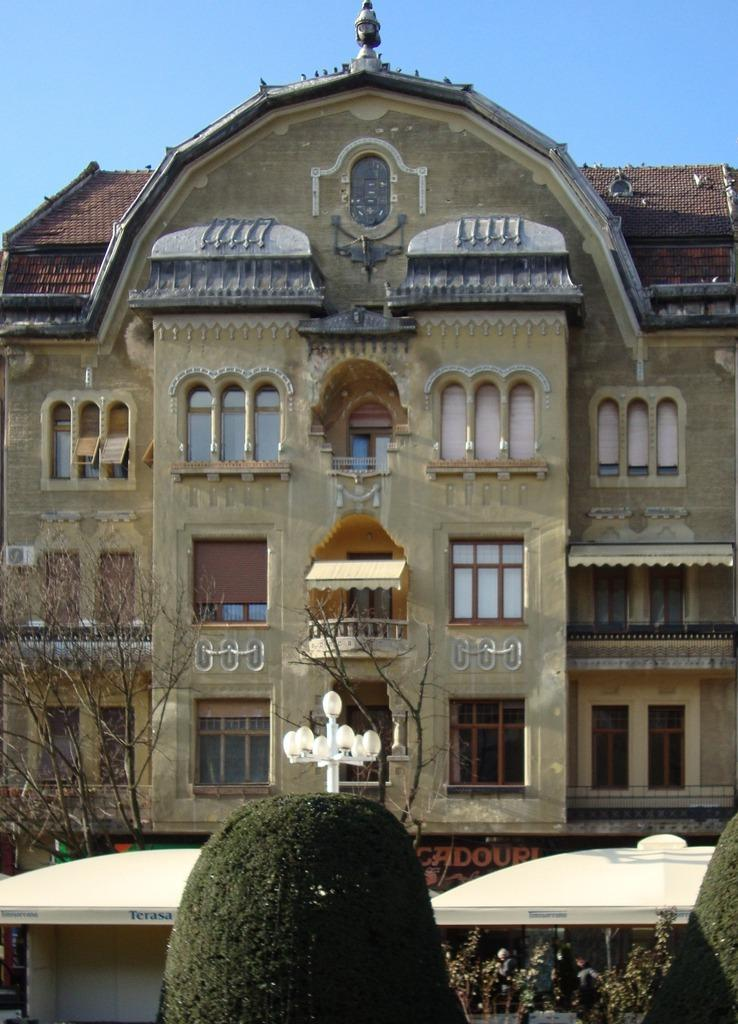

In [22]:
image = ds['test'][23]['pixel_values']
image

#### Prepare Image & Apply Model to It

In [23]:
# prep image for model
encoding = image_processor(image, return_tensors="pt")
pixel_values = encoding.pixel_values
print(pixel_values.shape)
outputs = model(pixel_values=pixel_values)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 3, 512, 512])
torch.Size([1, 12, 128, 128])


#### Define Function to Convert Segments to Their Respective Colors

In [24]:
def color_map(): 
    return [
    [  0,   0,   0],
    [  0,   0, 170],
    [  0,   0, 255],
    [  0,  85, 255],
    [  0, 170, 255],
    [  0, 255, 255],
    [ 85, 255, 170],
    [170,   0,   0],
    [170, 255,  85],
    [255,   0,   0],
    [255,  85,   0],
    [255, 170,   0],
    [255, 255,   0]]

#### Process Image & Mask, Then Display It

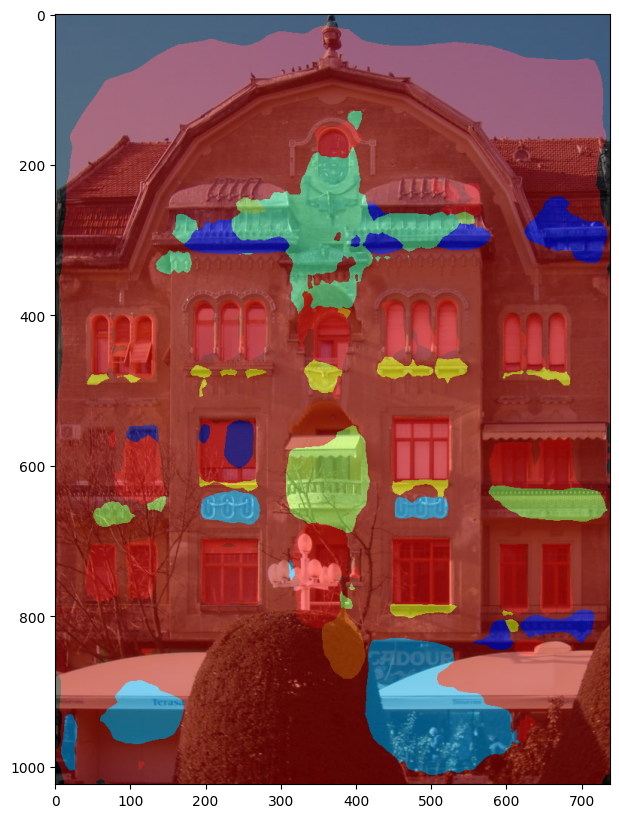

In [25]:
# First, rescale logits to original image size
upsampled_logits = torch.nn.functional.interpolate(logits,
                size=image.size[::-1],
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
segments = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((segments.shape[0], segments.shape[1], 3), dtype=np.uint8) #in the form of: height, width, 3
palette = np.array(color_map())
for label, color in enumerate(palette):
    color_seg[segments == label, :] = color
color_seg = color_seg[..., ::-1]

# Show image with mask over it
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

### Notes & Other Takeaways From This Project
****
- The difference between this project and the first version of this project is that I used higher Color Jitter values. They are:

| Color Jitter Attribute | Version 1 | This Project |
|:------:|:------:|:------:|
| Brightness | 0.25 | 0.50 |
| Contrast | 0.25 | 0.50 |
| Saturation | 0.25 | 0.50 |
| Hue | 0.10 | 0.25 |

- I am still not happy with the results of this project.

****

### Citations

- Model Checkpoint
    > @article{DBLP:journals/corr/abs-2105-15203, author = {Enze Xie and Wenhai Wang and Zhiding Yu and Anima Anandkumar and Jose M. Alvarez and Ping Luo}, title = {SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers}, journal = {CoRR}, volume = {abs/2105.15203}, year = {2021}, url = {https://arxiv.org/abs/2105.15203}, eprinttype = {arXiv}, eprint = {2105.15203}, timestamp = {Wed, 02 Jun 2021 11:46:42 +0200}, biburl = {https://dblp.org/rec/journals/corr/abs-2105-15203.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}

- Dataset
    > @INPROCEEDINGS{Tylecek13, author = {Radim Tyle{\v c}ek and Radim {\v S}{\' a}ra}, title = {Spatial Pattern Templates for Recognition of Objects with Regular Structure}, booktitle = {Proc. GCPR}, year = {2013}, address = {Saarbrucken, Germany},}